# Movie Recommendation System

Movie Recommendation Sytem using item-based collaborative filtering on the 25 million movielens dataset.

# **Importing Libraries required**

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
np.random.seed(123)
import seaborn as sns

!pip install pytorch-lightning
import pytorch_lightning as pl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 40.4 MB/s eta 0:00:00


In [2]:
# Adding movies dataset
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
#Adding ratings dataset
ratings = pd.read_csv('ratings.csv',
                      parse_dates=['timestamp'])
ratings.head()

<ipython-input-3-4f0f995ada58>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ratings = pd.read_csv('ratings.csv',


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
tags = pd.read_csv('tags.csv',
                      parse_dates=['timestamp'])
tags.head()

<ipython-input-4-0e6938bbcb0f>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tags = pd.read_csv('tags.csv',


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [5]:
tags.size

14732

# **Data Visualization**

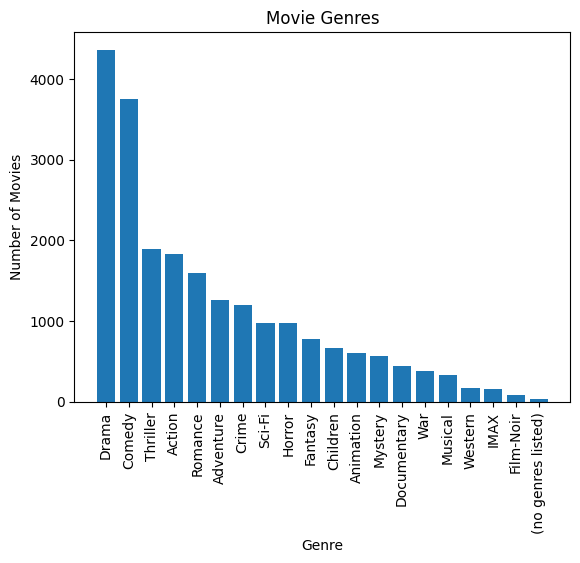

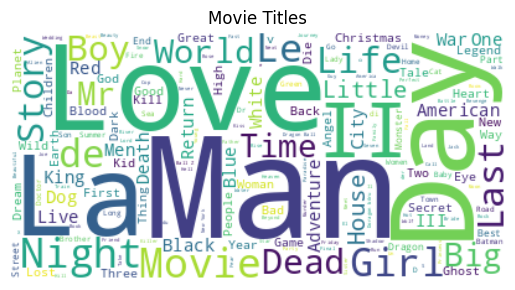

In [6]:
import matplotlib.pyplot as plt

# create a bar graph of movie genres
genres = movies['genres'].str.split('|', expand=True).stack().value_counts()
plt.bar(genres.index, genres.values)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movie Genres')
plt.show()

# create a word cloud of movie titles
from wordcloud import WordCloud

# join all movie titles into a single string
titles = ' '.join(movies['title'].tolist())

# generate word cloud
wordcloud = WordCloud(background_color='white').generate(titles)

# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Movie Titles')
plt.show()

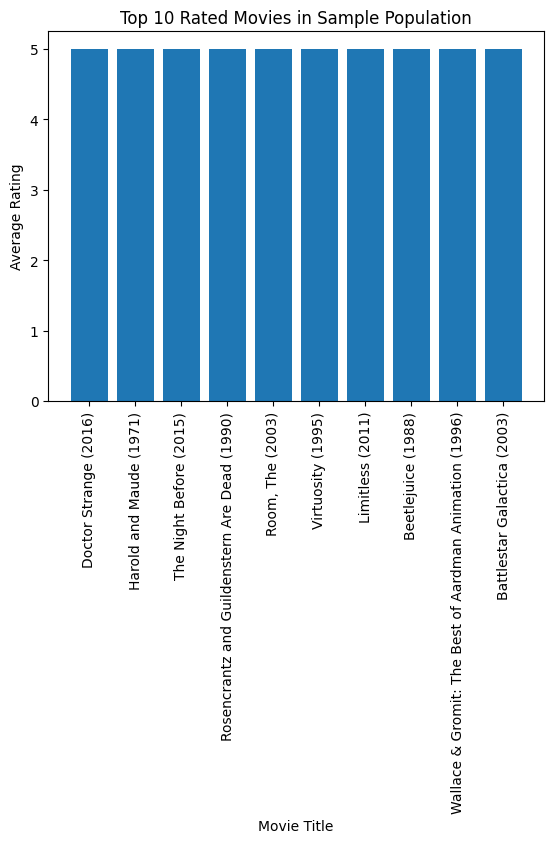

In [7]:
# merge ratings and movies dataset
merged_data = pd.merge(ratings, movies, on='movieId')

# get a random sample of the merged dataset
sample = merged_data.sample(n=1000)

# create a bar graph of the top 10 rated movies in the sample
top_10_rated_movies = sample.groupby(['title'])['rating'].mean().sort_values(ascending=False).head(10)
plt.bar(top_10_rated_movies.index, top_10_rated_movies.values)
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.title('Top 10 Rated Movies in Sample Population')
plt.show()


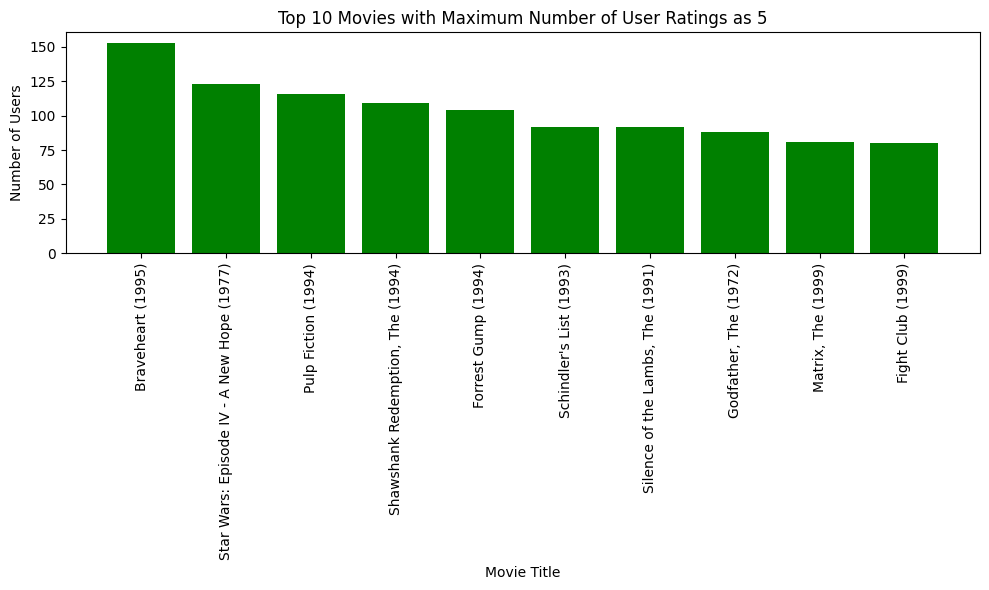

In [8]:
# Merge the movies and ratings dataframes using the movieid as the common column
merged_df = pd.merge(movies, ratings, on='movieId')

# Filter the merged dataframe to only include movies with a rating of 5
filtered_df = merged_df[merged_df['rating'] == 5]

# Group the filtered dataframe by the movieid and count the number of unique userids for each movie
grouped_df = filtered_df.groupby('movieId')['userId'].nunique()

# Get the top 10 movies with the highest number of users
top_10_movies = grouped_df.nlargest(10)

# Get the titles and number of users for the top 10 movies
result = movies[movies['movieId'].isin(top_10_movies.index)][['title', 'genres']]
result['num_users'] = top_10_movies.values

# Sort the result dataframe by the number of users in descending order
result = result.sort_values('num_users', ascending=False)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(result['title'], result['num_users'], color='green')
plt.xticks(rotation=90)
plt.xlabel('Movie Title')
plt.ylabel('Number of Users')
plt.title('Top 10 Movies with Maximum Number of User Ratings as 5')
plt.tight_layout()
plt.show()


In [9]:
merged_data = pd.merge(ratings, movies, on='movieId')

# filter movies with rating 5
rating_5_movies = merged_data[merged_data['rating'] == 5]

# count number of movies with rating 5
count = rating_5_movies.shape[0]

print("Number of movies with rating 5: ", count)

Number of movies with rating 5:  13211


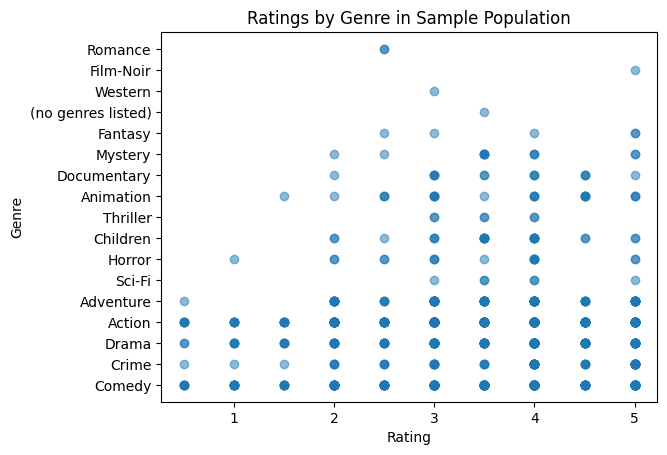

In [10]:
# create a scatter plot of ratings by genre
genres = movies['genres'].str.split('|', expand=True)
movies['primary_genre'] = genres[0]
sample_with_genre = pd.merge(sample, movies[['movieId', 'primary_genre']], on='movieId')

plt.scatter(sample_with_genre['rating'], sample_with_genre['primary_genre'], alpha=0.5)
plt.xlabel('Rating')
plt.ylabel('Genre')
plt.title('Ratings by Genre in Sample Population')
plt.show()


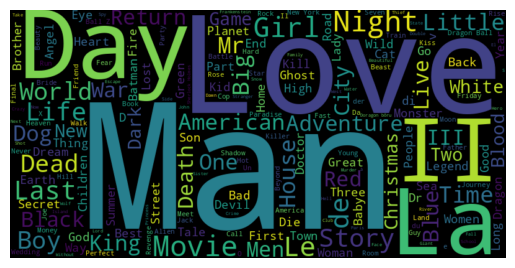

In [11]:
from wordcloud import WordCloud

# Concatenate all movie titles into a single string
all_titles = " ".join(movies["title"])

# Create a word cloud of the movie titles
wordcloud = WordCloud(width=800, height=400).generate(all_titles)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

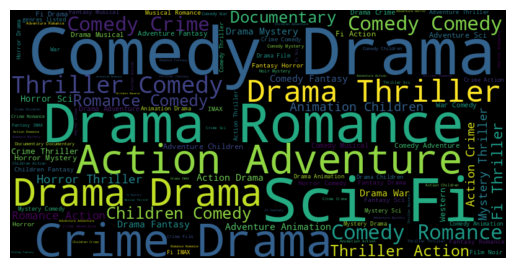

In [12]:
# Concatenate all movie titles into a single string
all_genres = " ".join(movies["genres"])

# Create a word cloud of the movie titles
wordcloud = WordCloud(width=800, height=400).generate(all_genres)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Train and Test Data**



In [ ]:
ratings['timestamp'] = ratings['timestamp']
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

# Splitting the data into training and testing data where rank either equal or not equal to 1
train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need which is timestamp since splitting is over
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(5)

,userId,movieId,rating
48199,312,4128,1.0
95240,600,914,1.0
2951,19,3705,1.0
59220,386,494,1.0
80132,503,5418,1.0


In [13]:
# Rank interactions per user based on timestamp in descending order
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

# Split into train, validation, and test sets based on rank
train_ratings = ratings[ratings['rank_latest'] > 2]
val_ratings = ratings[ratings['rank_latest'] == 2]
test_ratings = ratings[ratings['rank_latest'] == 1]

# Drop unneeded columns (timestamp and rank_latest)
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
val_ratings = val_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

# Set all training ratings to 1 to indicate positive interactions
train_ratings.loc[:, 'rating'] = 1

# Display a sample of the training data
train_ratings.sample(5)


,userId,movieId,rating
62277,413,6373,1.0
51732,334,4963,1.0
90963,590,3730,1.0
98510,607,480,1.0
43106,288,40583,1.0


In [ ]:
#Generating random nehative values (0) for each positive interaction (1) on the ratio of 4:1

# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds)
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/100226 [00:00<?, ?it/s]

In [33]:
from tqdm import tqdm
import numpy as np
import torch

# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Function to generate users, items, and labels with a 4:1 negative-to-positive ratio
def generate_samples(user_item_set, all_movieIds, num_negatives=4):
    users, items, labels = [], [], []
    for (u, i) in tqdm(user_item_set):
        # Positive interaction
        users.append(u)
        items.append(i)
        labels.append(1)

        # Generate negative samples
        for _ in range(num_negatives):
            negative_item = np.random.choice(all_movieIds)
            while (u, negative_item) in user_item_set:
                negative_item = np.random.choice(all_movieIds)
            users.append(u)
            items.append(negative_item)
            labels.append(0)  # Negative sample

    return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

# Generate samples for training set
train_user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))
train_users, train_items, train_labels = generate_samples(train_user_item_set, all_movieIds, num_negatives=4)

# Generate samples for validation set
val_user_item_set = set(zip(val_ratings['userId'], val_ratings['movieId']))
val_users, val_items, val_labels = generate_samples(val_user_item_set, all_movieIds, num_negatives=4)

# Generate samples for test set
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))
test_users, test_items, test_labels = generate_samples(test_user_item_set, all_movieIds, num_negatives=4)


100%|██████████| 610/610 [00:00<00:00, 12144.65it/s]


# Creating a class to generate tensors of user and item entires

In [34]:
class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training

    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds

    """

    def __init__(self, train_ratings, all_movieIds):
        self.train_users, self.train_items, self.train_labels = self.get_dataset(train_ratings, all_movieIds)

    def __len__(self):
        return len(self.train_users)

    def __getitem__(self, idx):
        return self.train_users[idx], self.train_items[idx], self.train_labels[idx]

    def get_dataset(self, train_ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users),torch.tensor(items),torch.tensor(labels)

In [35]:
class MovieLensValDataset(Dataset):
    """MovieLens PyTorch Dataset for Validation

    Args:
        ratings (pd.DataFrame): Dataframe containing the validation movie ratings
        all_movieIds (list): List containing all movieIds
    """

    def __init__(self, val_ratings, all_movieIds, num_negatives=2):
        self.val_users, self.val_items, self.val_labels = self.get_dataset(val_ratings, all_movieIds, num_negatives)

    def __len__(self):
        return len(self.val_users)

    def __getitem__(self, idx):
        return self.val_users[idx], self.val_items[idx], self.val_labels[idx]

    def get_dataset(self, val_ratings, all_movieIds, num_negatives):
        users, items, labels = [], [], []
        user_item_set = set(zip(val_ratings['userId'], val_ratings['movieId']))

        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)  # Positive sample

            # Adding a few negative samples for validation
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)  # Negative sample

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)


class MovieLensTestDataset(Dataset):
    """MovieLens PyTorch Dataset for Testing

    Args:
        ratings (pd.DataFrame): Dataframe containing the test movie ratings
        all_movieIds (list): List containing all movieIds
    """

    def __init__(self, test_ratings, all_movieIds, num_negatives=99):
        self.test_users, self.test_items, self.test_labels = self.get_dataset(test_ratings, all_movieIds, num_negatives)

    def __len__(self):
        return len(self.test_users)

    def __getitem__(self, idx):
        return self.test_users[idx], self.test_items[idx], self.test_labels[idx]

    def get_dataset(self, test_ratings, all_movieIds, num_negatives):
        users, items, labels = [], [], []
        user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)  # Positive sample

            # Adding more negative samples for testing
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)  # Negative sample

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)


# Creating a class to process the pytorch lightning model

In [ ]:
"""from torchmetrics.classification import Accuracy

class NCF(pl.LightningModule):
     Neural Collaborative Filtering (NCF)

        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)

    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")


    def forward(self, user_input, item_input):

        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred.squeeze(-1)

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())

        acc = self.train_accuracy(predicted_labels, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss


    def validation_step(self, batch, batch_idx):
        # Validation step
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())

        # Log validation accuracy
        acc = self.val_accuracy(predicted_labels, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        # Testing step, if needed
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())

        # Log test accuracy
        acc = self.val_accuracy(predicted_labels, labels)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return  DataLoader(MovieLensTrainDataset (self.ratings,self.all_movieIds), batch_size=512, num_workers=4)"""


In [ ]:
"""from torchmetrics.classification import Accuracy

class NCF(pl.LightningModule):
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")

    def forward(self, user_input, item_input):
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))
        pred = nn.Sigmoid()(self.output(vector))
        return pred.squeeze(-1)

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.float())

        acc = self.train_accuracy(predicted_labels, labels.int())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.float())

        acc = self.val_accuracy(predicted_labels, labels.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.float())

        acc = self.test_accuracy(predicted_labels, labels.int())
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds), batch_size=512, num_workers=4)

    def val_dataloader(self):
        return DataLoader(MovieLensValDataset(self.ratings, self.all_movieIds), batch_size=512, num_workers=4)

    def test_dataloader(self):
        return DataLoader(MovieLensTestDataset(self.ratings, self.all_movieIds), batch_size=512, num_workers=4)

In [56]:
import pytorch_lightning as pl
import torch
from torch import nn
import torch.nn.functional as F
from torchmetrics.classification import Accuracy

class NCF(pl.LightningModule):
    def __init__(self, num_users, num_items, train_ratings, val_ratings, test_ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)

        # GMF Component
        self.gmf = nn.Linear(8, 1)

        # MLP Layers (as in your code)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)

        # Final Prediction Layer after concatenating GMF and MLP
        self.output = nn.Linear(in_features=33, out_features=1)  # 32 from MLP + 1 from GMF

        # Accuracy Metrics
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")

        # Dataset-specific attributes
        self.train_ratings = train_ratings
        self.val_ratings = val_ratings
        self.test_ratings = test_ratings

        self.all_movieIds = all_movieIds

    def forward(self, user_input, item_input):
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # GMF: Element-wise multiplication
        gmf_out = self.gmf(user_embedded * item_embedded)

        # MLP: Concatenate and pass through dense layers
        mlp_out = torch.cat([user_embedded, item_embedded], dim=-1)
        mlp_out = nn.ReLU()(self.fc1(mlp_out))
        mlp_out = nn.ReLU()(self.fc2(mlp_out))

        # Concatenate GMF and MLP outputs
        concat_out = torch.cat([gmf_out, mlp_out], dim=-1)

        # Final prediction
        pred = torch.sigmoid(self.output(concat_out))
        return pred.squeeze(-1)

    def get_recommendations(self, user_id, num_recommendations=10):
        # Get a list of all items
        all_items = torch.arange(num_items)  # Adjust according to your item ID range
        user_tensor = torch.tensor([user_id] * len(all_items))  # Create a tensor for the user ID

        # Get the model's predictions for all items for the given user
        with torch.no_grad():
            scores = self.forward(user_tensor, all_items)

        # Sort scores to get the top recommended item indices
        _, top_indices = torch.topk(scores, num_recommendations)

        # Return the recommended item IDs
        return all_items[top_indices].tolist()


    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.float())

        acc = self.train_accuracy(predicted_labels, labels.int())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.float())

        acc = self.val_accuracy(predicted_labels, labels.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.float())

        acc = self.test_accuracy(predicted_labels, labels.int())
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.train_ratings, self.all_movieIds), batch_size=512, num_workers=4)

    def val_dataloader(self):
        return DataLoader(MovieLensValDataset(self.val_ratings, self.all_movieIds), batch_size=512, num_workers=4)

    def test_dataloader(self):
        return DataLoader(MovieLensTestDataset(self.test_ratings, self.all_movieIds), batch_size=512, num_workers=4)

In [ ]:
"""from torchmetrics.classification import Accuracy
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class NCF(pl.LightningModule):
    def __init__(self, num_users, num_items, train_ratings, val_ratings, test_ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)

        # Assign ratings for each dataset
        self.train_ratings = train_ratings
        self.val_ratings = val_ratings
        self.test_ratings = test_ratings

        self.all_movieIds = all_movieIds

        # Define accuracy metrics
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")

    def forward(self, user_input, item_input):
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))
        pred = self.output(vector)  # No sigmoid here; handled by BCEWithLogitsLoss in step functions
        return pred.squeeze(-1)

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCEWithLogitsLoss()(predicted_labels, labels.float())

        acc = self.train_accuracy(torch.sigmoid(predicted_labels), labels.int())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCEWithLogitsLoss()(predicted_labels, labels.float())

        acc = self.val_accuracy(torch.sigmoid(predicted_labels), labels.int())
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCEWithLogitsLoss()(predicted_labels, labels.float())

        acc = self.test_accuracy(torch.sigmoid(predicted_labels), labels.int())
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.train_ratings, self.all_movieIds), batch_size=512, num_workers=4)

    def val_dataloader(self):
        return DataLoader(MovieLensValDataset(self.val_ratings, self.all_movieIds), batch_size=512, num_workers=4)

    def test_dataloader(self):
        return DataLoader(MovieLensTestDataset(self.test_ratings, self.all_movieIds), batch_size=512, num_workers=4)


In [37]:
# Correcting the conversion to integer
num_users = int(ratings['userId'].max() + 1)
num_items = int(ratings['movieId'].max() + 1)

# Getting unique movie IDs as an array
all_movieIds = ratings['movieId'].unique()

# Initialize the NCF model
model = NCF(num_users, num_items, train_ratings, val_ratings, test_ratings, all_movieIds)

In [38]:
train_dataset = MovieLensTrainDataset(train_ratings, all_movieIds)
val_dataset = MovieLensValDataset(val_ratings, all_movieIds, num_negatives=2)
test_dataset = MovieLensTestDataset(test_ratings, all_movieIds, num_negatives=99)


train_dataloader = DataLoader(train_dataset, batch_size=512, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=512, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=512, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [43]:
# Check if a GPU is available and move model to GPU if so
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Set up the PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=10,
    logger=True,
)

# Fit the model (train and validate)
trainer.fit(model)

# Test the model
trainer.test(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | user_embedding | Embedding      | 4.9 K  | train
1 | item_embedding | Embedding      | 1.5 M  | train
2 | gmf            | Linear         | 9      | train
3 | fc1            | Linear         | 1.1 K  | train
4 | fc2            | Linear         | 2.1 K  | train
5 | output         | Linear         | 34     | train
6 | train_accuracy | BinaryAccuracy | 0      | train
7 | val_accuracy   | BinaryAccuracy | 0      | train
8 | test_accuracy  | BinaryAccuracy | 0      | train
----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9337213039398193     │
│         test_loss         │    0.17045368254184723    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.17045368254184723, 'test_acc': 0.9337213039398193}]

In [45]:
from tqdm import tqdm

# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = test_ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
device = "cuda" if torch.cuda.is_available() else "cpu"

for (u, i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)

    # Select 99 negative items to test alongside the positive item
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    # Move tensors to the GPU if available
    user_tensor = torch.tensor([u] * 100, device=device)
    item_tensor = torch.tensor(test_items, device=device)

    # Predict labels in evaluation mode without gradient tracking
    model.eval()
    with torch.no_grad():
        predicted_labels = model(user_tensor, item_tensor).cpu().numpy()

    # Get top 10 items
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][:10]]

    # Check if the actual item is in the top 10 predictions
    hits.append(1 if i in top10_items else 0)

# Calculate and print Hit Ratio @ 10
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

100%|██████████| 610/610 [00:04<00:00, 143.82it/s]

The Hit Ratio @ 10 is 0.58


In [46]:
print(hits), len(hits)

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 

(None, 610)

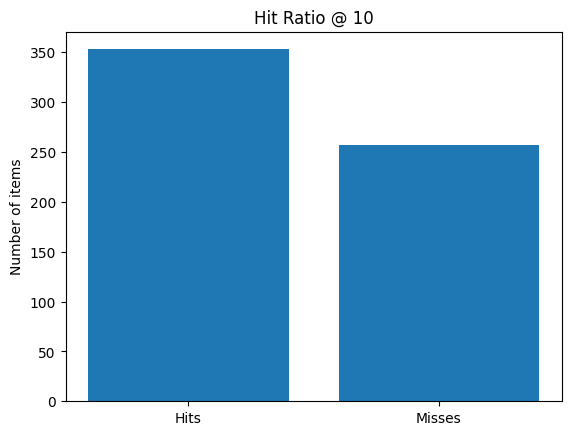

In [47]:
#graphically understanding the number of hits
import matplotlib.pyplot as plt

# Count the number of hits and misses
num_hits = sum(hits)
num_misses = len(hits) - num_hits

# Create a bar chart
plt.bar(['Hits', 'Misses'], [num_hits, num_misses])
plt.title('Hit Ratio @ 10')
plt.ylabel('Number of items')
plt.show()


In [48]:
print(top10_items)

[2028, 2628, 2947, 34162, 224, 2324, 52973, 1252, 2542, 1199]


In [49]:
# Create a dictionary of movie IDs and titles
id2title = {movie_id: movie_title for movie_id, movie_title in zip(movies["movieId"], movies["title"])}

# Iterate through the top 10 items in each hit and print their titles
for (u, i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    if i in top10_items:
        hits.append(1)
        top10_titles = [id2title[item] for item in top10_items]
        print(f"\nUser {u}, recommended movie '{id2title[i]}' was a hit!")
        print("Top 10 recommended movies:")
        for title in top10_titles:
            print(title)
    else:
        hits.append(0)

  5%|▌         | 31/610 [00:00<00:03, 148.80it/s]


User 69, recommended movie 'Cast Away (2000)' was a hit!
Top 10 recommended movies:
Dances with Wolves (1990)
Men in Black (a.k.a. MIB) (1997)
Cast Away (2000)
Rear Window (1954)
Scarface (1983)
Jackie Brown (1997)
Few Good Men, A (1992)
Trading Places (1983)
Emma (1996)
Escape from L.A. (1996)

User 283, recommended movie 'Home Alone (1990)' was a hit!
Top 10 recommended movies:
Home Alone (1990)
Chinatown (1974)
Tin Cup (1996)
Payback (1999)
Repo Man (1984)
Monty Python's The Meaning of Life (1983)
25th Hour (2002)
Oblivion (2013)
Doctor Strange (2016)
Frozen (2013)

User 396, recommended movie 'Toy Story 2 (1999)' was a hit!
Top 10 recommended movies:
Jaws (1975)
Toy Story 2 (1999)
Ace Ventura: When Nature Calls (1995)
French Kiss (1995)
Three Kings (1999)
So I Married an Axe Murderer (1993)
Deliverance (1972)
Dante's Peak (1997)
Michael Clayton (2007)
Scent of a Woman (1992)

User 36, recommended movie 'Shawshank Redemption, The (1994)' was a hit!
Top 10 recommended movies:
Matrix

  8%|▊         | 46/610 [00:00<00:04, 139.97it/s]


User 112, recommended movie 'District 9 (2009)' was a hit!
Top 10 recommended movies:
Seven (a.k.a. Se7en) (1995)
District 9 (2009)
Dead Poets Society (1989)
Billy Madison (1995)
Planet of the Apes (1968)
M*A*S*H (a.k.a. MASH) (1970)
Teenage Mutant Ninja Turtles (1990)
Patriot Games (1992)
African Queen, The (1951)
One Hour Photo (2002)

User 186, recommended movie 'Mission: Impossible (1996)' was a hit!
Top 10 recommended movies:
Mission: Impossible (1996)
Lost in Translation (2003)
Apocalypse Now (1979)
Erin Brockovich (2000)
Shining, The (1980)
Maltese Falcon, The (1941)
Sling Blade (1996)
Platoon (1986)
Down Periscope (1996)
Harold and Maude (1971)

User 335, recommended movie 'True Lies (1994)' was a hit!
Top 10 recommended movies:
True Lies (1994)
Big Lebowski, The (1998)
Spider-Man (2002)
Casino Royale (2006)
Three Musketeers, The (1993)
Vertigo (1958)
There Will Be Blood (2007)
Hellboy (2004)
Kingpin (1996)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)

User 327, recommended 

 10%|█         | 61/610 [00:00<00:04, 113.94it/s]


User 446, recommended movie 'To Die For (1995)' was a hit!
Top 10 recommended movies:
Shakespeare in Love (1998)
Love Actually (2003)
X-Men: First Class (2011)
To Die For (1995)
Super Troopers (2001)
Battle Royale (Batoru rowaiaru) (2000)
Fantastic Four: Rise of the Silver Surfer (2007)
In & Out (1997)
21 Jump Street (2012)
Grifters, The (1990)

User 29, recommended movie 'Enemy at the Gates (2001)' was a hit!
Top 10 recommended movies:
Indiana Jones and the Last Crusade (1989)
Kill Bill: Vol. 2 (2004)
Total Recall (1990)
Heavy Metal (1981)
Kiss Kiss Bang Bang (2005)
One Hour Photo (2002)
Gravity (2013)
Enemy at the Gates (2001)
Mickey Blue Eyes (1999)
8MM (1999)

User 94, recommended movie 'Jumanji (1995)' was a hit!
Top 10 recommended movies:
Ed Wood (1994)
One Flew Over the Cuckoo's Nest (1975)
Jumanji (1995)
Shrek 2 (2004)
Casino (1995)
My Cousin Vinny (1992)
Cinderella (1950)
Mad Max: Fury Road (2015)
Blade (1998)
Drive (2011)

User 382, recommended movie 'Into the Wild (2007)' w

 12%|█▏        | 73/610 [00:00<00:06, 82.33it/s] 


User 114, recommended movie 'Spider-Man (2002)' was a hit!
Top 10 recommended movies:
Spider-Man (2002)
Goldfinger (1964)
How to Train Your Dragon (2010)
School of Rock (2003)
Blazing Saddles (1974)
Secret Life of Walter Mitty, The (2013)
Double Jeopardy (1999)
Grease 2 (1982)
Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)
Zero Effect (1998)

User 426, recommended movie 'Pretty Woman (1990)' was a hit!
Top 10 recommended movies:
Trainspotting (1996)
Pretty Woman (1990)
Goodfellas (1990)
Pan's Labyrinth (Laberinto del fauno, El) (2006)
Deep Impact (1998)
Grease (1978)
Sleepy Hollow (1999)
Guardians of the Galaxy (2014)
Dangerous Minds (1995)
Harry Potter and the Deathly Hallows: Part 1 (2010)

User 215, recommended movie 'How to Lose a Guy in 10 Days (2003)' was a hit!
Top 10 recommended movies:
Groundhog Day (1993)
Eraser (1996)
O Brother, Where Art Thou? (2000)
Mystic River (2003)
Tomorrow Never Dies (1997)
Quick and the Dead, The (1995)
Old Boy (2003)
H

 14%|█▎        | 83/610 [00:00<00:06, 78.14it/s]


User 67, recommended movie 'Back to the Future Part III (1990)' was a hit!
Top 10 recommended movies:
Gladiator (2000)
Dark Knight, The (2008)
Finding Nemo (2003)
Back to the Future Part III (1990)
Anchorman: The Legend of Ron Burgundy (2004)
Pianist, The (2002)
Talented Mr. Ripley, The (1999)
Time to Kill, A (1996)
Little Shop of Horrors (1986)
My Best Friend's Wedding (1997)

User 482, recommended movie 'Team America: World Police (2004)' was a hit!
Top 10 recommended movies:
Snow White and the Seven Dwarfs (1937)
Star Trek (2009)
Beverly Hills Cop (1984)
Escape from L.A. (1996)
Crocodile Dundee (1986)
Aviator, The (2004)
Heavy Metal (1981)
Bonnie and Clyde (1967)
Team America: World Police (2004)
Howl's Moving Castle (Hauru no ugoku shiro) (2004)

User 147, recommended movie 'Three Musketeers, The (1993)' was a hit!
Top 10 recommended movies:
Dumb & Dumber (Dumb and Dumber) (1994)
Gone in 60 Seconds (2000)
Three Musketeers, The (1993)
Love Actually (2003)
Mulan (1998)
Whole Nine Ya

 16%|█▋        | 100/610 [00:01<00:07, 67.75it/s]


User 470, recommended movie 'Heat (1995)' was a hit!
Top 10 recommended movies:
Face/Off (1997)
Heat (1995)
Birdcage, The (1996)
Addams Family Values (1993)
Batman Returns (1992)
Dogma (1999)
Me, Myself & Irene (2000)
Heavy Metal (1981)
Tarzan (1999)
Naked Gun: From the Files of Police Squad!, The (1988)

User 276, recommended movie 'Apollo 13 (1995)' was a hit!
Top 10 recommended movies:
Men in Black (a.k.a. MIB) (1997)
Apollo 13 (1995)
Indiana Jones and the Temple of Doom (1984)
City Slickers II: The Legend of Curly's Gold (1994)
Space Jam (1996)
Wild Wild West (1999)
Planet of the Apes (1968)
Close Encounters of the Third Kind (1977)
Spider-Man 3 (2007)
Searching for Bobby Fischer (1993)

User 174, recommended movie 'Robin Hood: Men in Tights (1993)' was a hit!
Top 10 recommended movies:
Magnolia (1999)
Robin Hood: Men in Tights (1993)
Little Mermaid, The (1989)
Bill & Ted's Excellent Adventure (1989)
Nell (1994)
Wallace & Gromit: A Close Shave (1995)
Tropic Thunder (2008)
Down Per

 18%|█▊        | 108/610 [00:01<00:07, 63.37it/s]


Beetlejuice (1988)
Jumanji (1995)
Abyss, The (1989)
Terminator 3: Rise of the Machines (2003)
Hitch (2005)
Thank You for Smoking (2006)
Scott Pilgrim vs. the World (2010)

User 369, recommended movie 'Amadeus (1984)' was a hit!
Top 10 recommended movies:
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
As Good as It Gets (1997)
Young Frankenstein (1974)
The Hunger Games (2012)
Knocked Up (2007)
Amadeus (1984)
Crash (2004)
My Fair Lady (1964)
Strange Days (1995)
Arrival (2016)

User 479, recommended movie 'Star Trek: The Motion Picture (1979)' was a hit!
Top 10 recommended movies:
Serenity (2005)
Star Trek: The Motion Picture (1979)
Fantastic Four (2005)
Cruel Intentions (1999)
Replacements, The (2000)
King Kong (1933)
Bedknobs and Broomsticks (1971)
Virgin Suicides, The (1999)
Spy Who Loved Me, The (1977)
Along Came a Spider (2001)

User 150, recommended movie 'Time to Kill, A (1996)' was a hit!
Top 10 recommended movies:
Ed Wood (1994)
Twister (1996)
Inglourious Basterd

 21%|██        | 127/610 [00:01<00:06, 69.22it/s]


Heavenly Creatures (1994)
Legend of Drunken Master, The (Jui kuen II) (1994)

User 241, recommended movie 'Seven (a.k.a. Se7en) (1995)' was a hit!
Top 10 recommended movies:
Seven (a.k.a. Se7en) (1995)
Three Kings (1999)
Citizen Kane (1941)
Wedding Singer, The (1998)
It's a Wonderful Life (1946)
Stranger than Fiction (2006)
We Were Soldiers (2002)
Zombieland (2009)
Runaway Bride (1999)
Lone Star (1996)

User 444, recommended movie 'Four Weddings and a Funeral (1994)' was a hit!
Top 10 recommended movies:
Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006)
GoldenEye (1995)
Avengers, The (2012)
Four Weddings and a Funeral (1994)
Grease (1978)
Batman Returns (1992)
Knocked Up (2007)
X-Men: The Last Stand (2006)
Lethal Weapon 2 (1989)
Secret Garden, The (1993)

User 443, recommended movie 'Inception (2010)' was a hit!
Top 10 recommended movies:
Sixth Sense, The (1999)
Inception (2010)
Bourne Ultimatum, The (2007)
Mummy, The (1999)
Galaxy Quest (1999)

 25%|██▍       | 150/610 [00:01<00:05, 88.43it/s]


Bug's Life, A (1998)
Rock, The (1996)
Nightmare Before Christmas, The (1993)
Addams Family Values (1993)
Lost in Translation (2003)
Terminator 3: Rise of the Machines (2003)
Air Force One (1997)
Captain America: The First Avenger (2011)
Boogie Nights (1997)

User 103, recommended movie 'Bambi (1942)' was a hit!
Top 10 recommended movies:
Crow, The (1994)
Wedding Singer, The (1998)
Four Weddings and a Funeral (1994)
WALL·E (2008)
Psycho (1960)
Psycho (1960)
Beverly Hills Cop (1984)
Lethal Weapon 2 (1989)
Bambi (1942)
Cider House Rules, The (1999)

User 193, recommended movie 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)' was a hit!
Top 10 recommended movies:
Catch Me If You Can (2002)
Wizard of Oz, The (1939)
Hunt for Red October, The (1990)
Up (2009)
Spirited Away (Sen to Chihiro no kamikakushi) (2001)
Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)
I Am Legend (2007)
Perfect Storm, The (2000)
Christmas Vacation (National Lampoon's Christmas Vacation) (1

 28%|██▊       | 173/610 [00:02<00:04, 96.69it/s]


User 304, recommended movie 'Pretty Woman (1990)' was a hit!
Top 10 recommended movies:
Green Mile, The (1999)
Pretty Woman (1990)
American President, The (1995)
Legends of the Fall (1994)
Lady and the Tramp (1955)
Black Hawk Down (2001)
You've Got Mail (1998)
Robin Hood (1973)
Kick-Ass (2010)
African Queen, The (1951)

User 558, recommended movie 'There's Something About Mary (1998)' was a hit!
Top 10 recommended movies:
Monsters, Inc. (2001)
Monsters, Inc. (2001)
Nightmare Before Christmas, The (1993)
There's Something About Mary (1998)
Jaws (1975)
Lethal Weapon (1987)
Mask of Zorro, The (1998)
Last Samurai, The (2003)
Knocked Up (2007)
Rocky II (1979)

User 229, recommended movie 'Dead Man Walking (1995)' was a hit!
Top 10 recommended movies:
Dead Man Walking (1995)
O Brother, Where Art Thou? (2000)
Bruce Almighty (2003)
Princess Bride, The (1987)
Goldfinger (1964)
Young Frankenstein (1974)
Vanilla Sky (2001)
Dodgeball: A True Underdog Story (2004)
Kick-Ass (2010)
Heavy Metal (1981

 32%|███▏      | 196/610 [00:02<00:04, 102.65it/s]


Top 10 recommended movies:
Braveheart (1995)
Ghostbusters (a.k.a. Ghost Busters) (1984)
Monty Python's Life of Brian (1979)
Slumdog Millionaire (2008)
The Butterfly Effect (2004)
I, Robot (2004)
Italian Job, The (2003)
Naked Gun 33 1/3: The Final Insult (1994)
Sabrina (1995)
Brazil (1985)

User 449, recommended movie 'Platoon (1986)' was a hit!
Top 10 recommended movies:
Star Wars: Episode IV - A New Hope (1977)
Requiem for a Dream (2000)
Casino (1995)
Butch Cassidy and the Sundance Kid (1969)
Cinderella (1950)
Gran Torino (2008)
Mulholland Drive (2001)
Platoon (1986)
What Women Want (2000)
What's Love Got to Do with It? (1993)

User 399, recommended movie 'X2: X-Men United (2003)' was a hit!
Top 10 recommended movies:
Lord of the Rings: The Two Towers, The (2002)
Finding Nemo (2003)
Splash (1984)
X2: X-Men United (2003)
Liar Liar (1997)
2001: A Space Odyssey (1968)
Pocahontas (1995)
Superman (1978)
There Will Be Blood (2007)
Star Wars: Episode VII - The Force Awakens (2015)

User 565

 36%|███▌      | 220/610 [00:02<00:03, 105.78it/s]

Top 10 recommended movies:
Babe (1995)
Rock, The (1996)
Blade (1998)
Outbreak (1995)
Dead Poets Society (1989)
Hot Fuzz (2007)
Charlie and the Chocolate Factory (2005)
Wayne's World (1992)
Gone in 60 Seconds (2000)
Legally Blonde (2001)

User 122, recommended movie 'Social Network, The (2010)' was a hit!
Top 10 recommended movies:
In the Line of Fire (1993)
Akira (1988)
Pearl Harbor (2001)
Social Network, The (2010)
Annie Hall (1977)
Deer Hunter, The (1978)
Man on the Moon (1999)
Ransom (1996)
The Devil's Advocate (1997)
Thomas Crown Affair, The (1999)

User 320, recommended movie 'Avatar (2009)' was a hit!
Top 10 recommended movies:
Gattaca (1997)
Good Will Hunting (1997)
Big Lebowski, The (1998)
Avatar (2009)
Knocked Up (2007)
Underworld (2003)
Platoon (1986)
Unbreakable (2000)
The Machinist (2004)
Scream 3 (2000)

User 244, recommended movie 'Bad Boys (1995)' was a hit!
Top 10 recommended movies:
Ferris Bueller's Day Off (1986)
Lethal Weapon (1987)
Singin' in the Rain (1952)
Planet 

 40%|███▉      | 243/610 [00:02<00:03, 106.61it/s]


Insider, The (1999)
Hook (1991)
Monty Python's The Meaning of Life (1983)
Red Dragon (2002)
Rudy (1993)

User 371, recommended movie 'Fear and Loathing in Las Vegas (1998)' was a hit!
Top 10 recommended movies:
Men in Black (a.k.a. MIB) (1997)
Alien (1979)
Waterworld (1995)
Shaun of the Dead (2004)
Antz (1998)
Little Women (1994)
Whiplash (2014)
Fear and Loathing in Las Vegas (1998)
Stardust (2007)
Sideways (2004)

User 584, recommended movie 'Indian in the Cupboard, The (1995)' was a hit!
Top 10 recommended movies:
Clear and Present Danger (1994)
O Brother, Where Art Thou? (2000)
Crow, The (1994)
High Fidelity (2000)
Truth About Cats & Dogs, The (1996)
Wallace & Gromit in The Curse of the Were-Rabbit (2005)
Indian in the Cupboard, The (1995)
Life Aquatic with Steve Zissou, The (2004)
Hancock (2008)
Little Big Man (1970)

User 556, recommended movie 'Guardians of the Galaxy (2014)' was a hit!
Top 10 recommended movies:
Beautiful Mind, A (2001)
Sin City (2005)
Sense and Sensibility (19

 44%|████▎     | 266/610 [00:02<00:03, 107.49it/s]

Top 10 recommended movies:
Minority Report (2002)
Young Frankenstein (1974)
Captain America: The First Avenger (2011)
Pay It Forward (2000)
Small Soldiers (1998)
Yes Man (2008)
BASEketball (1998)
Beverly Hills Ninja (1997)
Sister Act 2: Back in the Habit (1993)
RocknRolla (2008)

User 192, recommended movie 'Jurassic Park (1993)' was a hit!
Top 10 recommended movies:
Jurassic Park (1993)
Star Wars: Episode II - Attack of the Clones (2002)
X2: X-Men United (2003)
Star Trek II: The Wrath of Khan (1982)
Galaxy Quest (1999)
Rocketeer, The (1991)
Citizen Kane (1941)
Little Shop of Horrors (1986)
Platoon (1986)
Labyrinth (1986)

User 207, recommended movie 'American History X (1998)' was a hit!
Top 10 recommended movies:
Mission: Impossible (1996)
American History X (1998)
There's Something About Mary (1998)
Congo (1995)
Vanilla Sky (2001)
Star Wars: Episode VII - The Force Awakens (2015)
Hotel Rwanda (2004)
Nine Months (1995)
Ocean's Twelve (2004)
Police Academy (1984)

User 227, recommende

 45%|████▌     | 277/610 [00:02<00:03, 107.76it/s]


User 510, recommended movie 'Sixth Sense, The (1999)' was a hit!
Top 10 recommended movies:
Lord of the Rings: The Fellowship of the Ring, The (2001)
Sixth Sense, The (1999)
Toy Story 2 (1999)
Miss Congeniality (2000)
Crash (2004)
Sabrina (1995)
Heathers (1989)
First Knight (1995)
21 Jump Street (2012)
Sunshine (2007)

User 576, recommended movie 'Player, The (1992)' was a hit!
Top 10 recommended movies:
Mummy, The (1999)
WALL·E (2008)
Anchorman: The Legend of Ron Burgundy (2004)
Fast and the Furious, The (2001)
50 First Dates (2004)
Courage Under Fire (1996)
X-Men: Days of Future Past (2014)
Forgetting Sarah Marshall (2008)
Player, The (1992)
True Grit (2010)

User 559, recommended movie 'Men in Black (a.k.a. MIB) (1997)' was a hit!
Top 10 recommended movies:
Godfather, The (1972)
Men in Black (a.k.a. MIB) (1997)
Alien (1979)
Avatar (2009)
Bourne Ultimatum, The (2007)
Pirates of the Caribbean: Dead Man's Chest (2006)
Fantasia (1940)
Gone with the Wind (1939)
Three Musketeers, The (19

 49%|████▉     | 301/610 [00:03<00:02, 106.15it/s]


User 164, recommended movie 'Men in Black (a.k.a. MIB) (1997)' was a hit!
Top 10 recommended movies:
Men in Black (a.k.a. MIB) (1997)
Apocalypse Now (1979)
Outbreak (1995)
There's Something About Mary (1998)
Game, The (1997)
Grosse Pointe Blank (1997)
Moulin Rouge (2001)
Cider House Rules, The (1999)
World Is Not Enough, The (1999)
Delicatessen (1991)

User 312, recommended movie 'Die Another Day (2002)' was a hit!
Top 10 recommended movies:
Bourne Supremacy, The (2004)
Truth About Cats & Dogs, The (1996)
In Bruges (2008)
Gods Must Be Crazy, The (1980)
Die Another Day (2002)
Help, The (2011)
Son in Law (1993)
Just Cause (1995)
Paul (2011)
Louis C.K.: Hilarious (2010)

User 336, recommended movie 'Corpse Bride (2005)' was a hit!
Top 10 recommended movies:
Sixth Sense, The (1999)
Austin Powers in Goldmember (2002)
Jerry Maguire (1996)
Mask of Zorro, The (1998)
Corpse Bride (2005)
Planet of the Apes (1968)
Gone with the Wind (1939)
Chicago (2002)
Rogue One: A Star Wars Story (2016)
Spy H

 53%|█████▎    | 324/610 [00:03<00:02, 103.29it/s]


User 378, recommended movie 'Memento (2000)' was a hit!
Top 10 recommended movies:
Memento (2000)
Men in Black (a.k.a. MIB) (1997)
Kill Bill: Vol. 2 (2004)
Kill Bill: Vol. 1 (2003)
Top Gun (1986)
Singin' in the Rain (1952)
Wedding Crashers (2005)
Executive Decision (1996)
Nell (1994)
Children of Men (2006)

User 199, recommended movie 'Run Lola Run (Lola rennt) (1998)' was a hit!
Top 10 recommended movies:
L.A. Confidential (1997)
Beetlejuice (1988)
Run Lola Run (Lola rennt) (1998)
Few Good Men, A (1992)
King's Speech, The (2010)
Harry Potter and the Deathly Hallows: Part 2 (2011)
Secret Garden, The (1993)
Mystery Science Theater 3000: The Movie (1996)
Sliding Doors (1998)
Robin Hood: Prince of Thieves (1991)

User 430, recommended movie 'Blue Velvet (1986)' was a hit!
Top 10 recommended movies:
Mars Attacks! (1996)
Dragonheart (1996)
Blue Velvet (1986)
Pearl Harbor (2001)
Field of Dreams (1989)
Lethal Weapon 3 (1992)
Con Air (1997)
U-571 (2000)
Dog Day Afternoon (1975)
Coming to Amer

 59%|█████▊    | 357/610 [00:03<00:02, 104.30it/s]


User 423, recommended movie 'Terminator 2: Judgment Day (1991)' was a hit!
Top 10 recommended movies:
Terminator 2: Judgment Day (1991)
Seven (a.k.a. Se7en) (1995)
Shakespeare in Love (1998)
Fly, The (1986)
Pi (1998)
Mummy Returns, The (2001)
Waterboy, The (1998)
Brokeback Mountain (2005)
City Slickers (1991)
Great Gatsby, The (2013)

User 589, recommended movie 'Dumb & Dumber (Dumb and Dumber) (1994)' was a hit!
Top 10 recommended movies:
Dark Knight, The (2008)
Dumb & Dumber (Dumb and Dumber) (1994)
GoldenEye (1995)
Little Miss Sunshine (2006)
Anchorman: The Legend of Ron Burgundy (2004)
RoboCop (1987)
Moulin Rouge (2001)
Englishman Who Went Up a Hill But Came Down a Mountain, The (1995)
Team America: World Police (2004)
Lost in Space (1998)

User 17, recommended movie 'Raging Bull (1980)' was a hit!
Top 10 recommended movies:
GoldenEye (1995)
Outbreak (1995)
Spider-Man 2 (2004)
Deep Impact (1998)
Road to Perdition (2002)
Long Kiss Goodnight, The (1996)
Inside Out (2015)
Big Daddy (

 62%|██████▏   | 379/610 [00:03<00:02, 101.59it/s]


User 539, recommended movie 'Kung Fu Panda (2008)' was a hit!
Top 10 recommended movies:
Total Recall (1990)
Hangover, The (2009)
Spider-Man 2 (2004)
Kung Fu Panda (2008)
First Knight (1995)
Full Monty, The (1997)
Full Monty, The (1997)
Secret Garden, The (1993)
Lucky Number Slevin (2006)
Conan the Barbarian (1982)

User 235, recommended movie 'Independence Day (a.k.a. ID4) (1996)' was a hit!
Top 10 recommended movies:
Independence Day (a.k.a. ID4) (1996)
Star Trek: First Contact (1996)
Who Framed Roger Rabbit? (1988)
Grease (1978)
Bill & Ted's Excellent Adventure (1989)
Executive Decision (1996)
Goonies, The (1985)
Old Boy (2003)
Social Network, The (2010)
RoboCop 3 (1993)

User 394, recommended movie 'Usual Suspects, The (1995)' was a hit!
Top 10 recommended movies:
Usual Suspects, The (1995)
Dragonheart (1996)
NeverEnding Story, The (1984)
Under Siege 2: Dark Territory (1995)
Copycat (1995)
Roger & Me (1989)
Ghost World (2001)
We Were Soldiers (2002)
Excalibur (1981)
Phantom, The (

 66%|██████▌   | 404/610 [00:04<00:01, 110.42it/s]


User 148, recommended movie 'V for Vendetta (2006)' was a hit!
Top 10 recommended movies:
V for Vendetta (2006)
Broken Arrow (1996)
Die Hard 2 (1990)
Crocodile Dundee (1986)
Dave (1993)
Repo Man (1984)
Primal Fear (1996)
Super Troopers (2001)
Striptease (1996)
Of Mice and Men (1992)

User 13, recommended movie 'Cell, The (2000)' was a hit!
Top 10 recommended movies:
Catch Me If You Can (2002)
Star Wars: Episode II - Attack of the Clones (2002)
Cell, The (2000)
Great Escape, The (1963)
Me, Myself & Irene (2000)
William Shakespeare's Romeo + Juliet (1996)
Carrie (1976)
Harold and Kumar Go to White Castle (2004)
Better Off Dead... (1985)
Sex, Lies, and Videotape (1989)

User 329, recommended movie 'Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)' was a hit!
Top 10 recommended movies:
Clockwork Orange, A (1971)
WALL·E (2008)
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)
Junior (1994)
Hellboy (2004)
Beavis and Butt-Head Do America (1996

 68%|██████▊   | 416/610 [00:04<00:01, 102.69it/s]


User 14, recommended movie 'Cable Guy, The (1996)' was a hit!
Top 10 recommended movies:
Big (1988)
Thing, The (1982)
Italian Job, The (2003)
Juno (2007)
Cable Guy, The (1996)
Annie Hall (1977)
Karate Kid, The (1984)
Home Alone 2: Lost in New York (1992)
Wanted (2008)
Scanner Darkly, A (2006)

User 287, recommended movie 'Apocalypse Now (1979)' was a hit!
Top 10 recommended movies:
Godfather: Part II, The (1974)
V for Vendetta (2006)
Apocalypse Now (1979)
Dogma (1999)
Nutty Professor, The (1996)
Inside Man (2006)
Multiplicity (1996)
Live and Let Die (1973)
Grease 2 (1982)
Underworld: Evolution (2006)

User 176, recommended movie 'Seven (a.k.a. Se7en) (1995)' was a hit!
Top 10 recommended movies:
Seven (a.k.a. Se7en) (1995)
Dead Man Walking (1995)
River Wild, The (1994)
Rush Hour 2 (2001)
Hoop Dreams (1994)
Fighter, The (2010)
The Hateful Eight (2015)
Island of Dr. Moreau, The (1996)
Big Momma's House (2000)
The Scorpion King (2002)

User 361, recommended movie 'Casino Royale (2006)' w

 72%|███████▏  | 439/610 [00:04<00:01, 102.13it/s]


User 223, recommended movie 'Pan's Labyrinth (Laberinto del fauno, El) (2006)' was a hit!
Top 10 recommended movies:
Jaws (1975)
Star Wars: Episode II - Attack of the Clones (2002)
Pan's Labyrinth (Laberinto del fauno, El) (2006)
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
Dark Knight Rises, The (2012)
Blue Velvet (1986)
Panic Room (2002)
Dr. No (1962)
Whole Nine Yards, The (2000)
Hackers (1995)

User 80, recommended movie 'Tucker & Dale vs Evil (2010)' was a hit!
Top 10 recommended movies:
Seven (a.k.a. Se7en) (1995)
Maverick (1994)
Dog Day Afternoon (1975)
Little Shop of Horrors (1986)
Iron Giant, The (1999)
Rounders (1998)
Girl with the Dragon Tattoo, The (Män som hatar kvinnor) (2009)
Faculty, The (1998)
Tucker & Dale vs Evil (2010)
Inside Job (2010)

User 458, recommended movie 'Jumanji (1995)' was a hit!
Top 10 recommended movies:
Gladiator (2000)
Jumanji (1995)
Last Action Hero (1993)
School of Rock (2003)
Outbreak (1995)
Little Miss Sunshine (2006)
Mulan (1998)
The Hu

 79%|███████▊  | 480/610 [00:04<00:01, 124.29it/s]


User 497, recommended movie 'Fargo (1996)' was a hit!
Top 10 recommended movies:
Shawshank Redemption, The (1994)
Fargo (1996)
Indiana Jones and the Last Crusade (1989)
Contact (1997)
Erin Brockovich (2000)
Enemy at the Gates (2001)
Transporter, The (2002)
Downfall (Untergang, Der) (2004)
Bodyguard, The (1992)
City Slickers (1991)

User 7, recommended movie 'Holiday, The (2006)' was a hit!
Top 10 recommended movies:
Harry Potter and the Deathly Hallows: Part 1 (2010)
Blue Velvet (1986)
Miracle on 34th Street (1994)
Holiday, The (2006)
Muppet Treasure Island (1996)
It Could Happen to You (1994)
Beverly Hills Cop II (1987)
Rocky Balboa (2006)
Blades of Glory (2007)
Serious Man, A (2009)

User 213, recommended movie 'Godfather, The (1972)' was a hit!
Top 10 recommended movies:
Godfather, The (1972)
Clueless (1995)
Erin Brockovich (2000)
Scott Pilgrim vs. the World (2010)
Pirates of the Caribbean: At World's End (2007)
About a Boy (2002)
Pinocchio (1940)
I, Robot (2004)
Antz (1998)
Apocal

 81%|████████  | 493/610 [00:04<00:00, 122.05it/s]


User 438, recommended movie 'Walk the Line (2005)' was a hit!
Top 10 recommended movies:
Lord of the Rings: The Two Towers, The (2002)
Brazil (1985)
Dead Poets Society (1989)
Sideways (2004)
About Schmidt (2002)
Easy A (2010)
Super Troopers (2001)
Wild Things (1998)
Spy Game (2001)
Walk the Line (2005)

User 343, recommended movie 'Schindler's List (1993)' was a hit!
Top 10 recommended movies:
Schindler's List (1993)
Star Wars: Episode II - Attack of the Clones (2002)
Net, The (1995)
Taxi Driver (1976)
Mummy, The (1999)
Patriot, The (2000)
Lost World: Jurassic Park, The (1997)
Gone in 60 Seconds (2000)
Dave (1993)
Scott Pilgrim vs. the World (2010)

User 490, recommended movie 'Eternal Sunshine of the Spotless Mind (2004)' was a hit!
Top 10 recommended movies:
X-Men (2000)
Eternal Sunshine of the Spotless Mind (2004)
Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)
X-Men: The Last Stand (2006)
Antz (1998)
Knocked Up (2007)
Village, The (2004)
Dr. Dolittle (1998)


 86%|████████▌ | 525/610 [00:05<00:00, 138.73it/s]


User 46, recommended movie 'Judge Dredd (1995)' was a hit!
Top 10 recommended movies:
Dragonheart (1996)
Day After Tomorrow, The (2004)
Judge Dredd (1995)
Nine Months (1995)
Hot Shots! Part Deux (1993)
Trading Places (1983)
Field of Dreams (1989)
Tomorrow Never Dies (1997)
King's Speech, The (2010)
Emma (1996)

User 268, recommended movie 'Life Is Beautiful (La Vita è bella) (1997)' was a hit!
Top 10 recommended movies:
Fight Club (1999)
Speed (1994)
Finding Nemo (2003)
Bourne Ultimatum, The (2007)
Avatar (2009)
Knocked Up (2007)
Life Is Beautiful (La Vita è bella) (1997)
Escape from New York (1981)
Gremlins (1984)
xXx (2002)

User 64, recommended movie 'Bambi (1942)' was a hit!
Top 10 recommended movies:
Casino Royale (2006)
Mad Max: Fury Road (2015)
Fast and the Furious, The (2001)
Election (1999)
Little Mermaid, The (1989)
Bambi (1942)
Dog Day Afternoon (1975)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)
Multiplicity (1996)
Striptease (1996)

User 126, recommended movie 'Babe (19

 94%|█████████▎| 571/610 [00:05<00:00, 142.74it/s]


User 351, recommended movie 'No Country for Old Men (2007)' was a hit!
Top 10 recommended movies:
Gangs of New York (2002)
Juno (2007)
No Country for Old Men (2007)
Bridget Jones's Diary (2001)
Star Trek: The Motion Picture (1979)
Star Trek (2009)
Darjeeling Limited, The (2007)
Evolution (2001)
Babel (2006)
Terms of Endearment (1983)

User 457, recommended movie 'eXistenZ (1999)' was a hit!
Top 10 recommended movies:
Alien (1979)
Jaws (1975)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Mad Max: Fury Road (2015)
Knocked Up (2007)
Tank Girl (1995)
eXistenZ (1999)
Hancock (2008)
Rogue One: A Star Wars Story (2016)
Free Willy (1993)

User 118, recommended movie 'Leaving Las Vegas (1995)' was a hit!
Top 10 recommended movies:
Big (1988)
Leaving Las Vegas (1995)
50 First Dates (2004)
Lives of Others, The (Das leben der Anderen) (2006)
Scary Movie (2000)
Last of the Mohicans, The (1992)
Bill & Ted's Bogus Journey (1991)
Doctor Zhivago (1965)
In Time (2011)
Girl

 96%|█████████▌| 587/610 [00:05<00:00, 145.47it/s]


User 569, recommended movie 'Net, The (1995)' was a hit!
Top 10 recommended movies:
Net, The (1995)
WALL·E (2008)
Bourne Ultimatum, The (2007)
Pianist, The (2002)
Philadelphia (1993)
Payback (1999)
Blind Side, The  (2009)
Cable Guy, The (1996)
Hollow Man (2000)
Good bye, Lenin! (2003)

User 4, recommended movie 'What About Bob? (1991)' was a hit!
Top 10 recommended movies:
Hunt for Red October, The (1990)
Departed, The (2006)
Contact (1997)
Harry Potter and the Chamber of Secrets (2002)
Sense and Sensibility (1995)
What About Bob? (1991)
Legally Blonde (2001)
Philadelphia (1993)
Misery (1990)
Interstellar (2014)

User 44, recommended movie 'Chasing Amy (1997)' was a hit!
Top 10 recommended movies:
Shrek (2001)
Chasing Amy (1997)
In the Line of Fire (1993)
Da Vinci Code, The (2006)
Lara Croft: Tomb Raider (2001)
Much Ado About Nothing (1993)
Unforgiven (1992)
Boys Don't Cry (1999)
My Fair Lady (1964)
Dude, Where's My Car? (2000)

User 332, recommended movie 'Sister Act (1992)' was a hi

100%|██████████| 610/610 [00:05<00:00, 105.10it/s]


Ice Age (2002)
Young Frankenstein (1974)
Edward Scissorhands (1990)
For a Few Dollars More (Per qualche dollaro in più) (1965)
Specialist, The (1994)
Panic Room (2002)
Bedazzled (2000)
Drop Zone (1994)
13th Warrior, The (1999)

User 10, recommended movie 'Dirty Dancing (1987)' was a hit!
Top 10 recommended movies:
Ghostbusters (a.k.a. Ghost Busters) (1984)
Dark Knight, The (2008)
Prestige, The (2006)
Willow (1988)
Ghostbusters II (1989)
Dirty Dancing (1987)
Spy Kids (2001)
Charlotte's Web (1973)
Ever After: A Cinderella Story (1998)
Milk Money (1994)

User 349, recommended movie 'Bad Boys (1995)' was a hit!
Top 10 recommended movies:
L.A. Confidential (1997)
Outbreak (1995)
Trading Places (1983)
Vanilla Sky (2001)
Flintstones, The (1994)
Bowling for Columbine (2002)
Specialist, The (1994)
Gremlins (1984)
Forever Young (1992)
Bad Boys (1995)

User 417, recommended movie 'Hobbit: The Desolation of Smaug, The (2013)' was a hit!
Top 10 recommended movies:
X-Men (2000)
Bourne Identity, The

In [29]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import numpy as np
import pandas as pd
from torchmetrics.classification import Accuracy
from torch.utils.data import DataLoader

# Assuming the NCF model and dataset classes are defined here (same as before)

# User feedback system
def get_user_feedback(user_id, recommended_movies):
    print(f"\nUser {user_id}, here are your recommended movies:")
    for idx, movie_id in enumerate(recommended_movies):
        print(f"{idx + 1}: {id2title[movie_id]}")

    # Initialize a list to collect feedback
    feedback = []
    for idx, movie_id in enumerate(recommended_movies):
        response = input(f"Do you like '{id2title[movie_id]}'? (yes/no): ").strip().lower()
        feedback.append(response)

    return feedback

def retrain_model(model, train_ratings, val_ratings):
    # Retraining the model using the provided training and validation data
    trainer = pl.Trainer(max_epochs=10, logger=True)
    trainer.fit(model)

# Example of running the user feedback system
def main():
    # Assuming the ratings DataFrame and movie DataFrame are loaded as 'ratings' and 'movies'
    num_users = int(ratings['userId'].max() + 1)
    num_items = int(ratings['movieId'].max() + 1)
    all_movieIds = ratings['movieId'].unique()

    # Initialize the NCF model
    model = NCF(num_users, num_items, train_ratings, val_ratings, test_ratings, all_movieIds)

    # Load existing model weights if available
    # model.load_from_checkpoint(checkpoint_path='path/to/checkpoint')

    # Ask user for their ID
    user_id = int(input("Please enter your user ID: "))

    # Get test user-item set
    test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

    # Get recommendations
    recommended_movies = []
    for (u, i) in test_user_item_set:
        if u == user_id:
            interacted_items = user_interacted_items[u]
            not_interacted_items = set(all_movieIds) - set(interacted_items)
            selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
            test_items = selected_not_interacted + [i]

            predicted_labels = np.squeeze(model(torch.tensor([u] * 100),
                                                torch.tensor(test_items)).detach().numpy())

            top10_items = [test_items[idx] for idx in np.argsort(predicted_labels)[::-1][:10]]
            recommended_movies = top10_items
            break  # Exit the loop after getting recommendations for the specified user

    # Get feedback from the user for all recommendations
    feedback = get_user_feedback(user_id, recommended_movies)

    # Check if any movies were disliked
    if any(response == 'no' for response in feedback):
        print("Retraining the model based on your feedback...")
        # Here you would ideally update the training data based on feedback,
        # but for simplicity, we will retrain with the existing dataset.
        retrain_model(model, train_ratings, val_ratings)
        print("Model retraining completed.")
    else:
        print("Thank you for your feedback! No retraining needed.")

if __name__ == "__main__":
    main()

Please enter your user ID: 123

User 123, here are your recommended movies:
1: Troll Hunter, The (Trolljegeren) (2010)
2: Catch a Fire (2006)
3: Jagged Edge (1985)
4: Pawn (2013)
5: Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993)
6: Mother Night (1996)
7: Rivers and Tides (2001)
8: Court Jester, The (1956)
9: 10 Years (2011)
10: Lagaan: Once Upon a Time in India (2001)
Do you like 'Troll Hunter, The (Trolljegeren) (2010)'? (yes/no): yes
Do you like 'Catch a Fire (2006)'? (yes/no): yes
Do you like 'Jagged Edge (1985)'? (yes/no): yes
Do you like 'Pawn (2013)'? (yes/no): yes
Do you like 'Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993)'? (yes/no): yes
Do you like 'Mother Night (1996)'? (yes/no): no
Do you like 'Rivers and Tides (2001)'? (yes/no): no
Do you like 'Court Jester, The (1956)'? (yes/no): yes
Do you like '10 Years (2011)'? (yes/no): no
Do you like 'Lagaan: Once Upon a Time in Ind

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | user_embedding | Embedding      | 4.9 K  | train
1 | item_embedding | Embedding      | 1.5 M  | train
2 | gmf            | Linear         | 9      | train
3 | fc1            | Linear         | 1.1 K  | train
4 | fc2            | Linear         | 2.1 K  | train
5 | output         | Linear         | 34     | train
6 | train_accuracy | BinaryAccuracy | 0      | train
7 | val_accuracy   | BinaryAccuracy | 0      | train
8 | test_accuracy  | BinaryAccuracy | 0      | train
----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M 

Retraining the model based on your feedback...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Model retraining completed.


In [30]:
trainer.test(model)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9220655560493469     │
│         test_loss         │     0.188420370221138     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.188420370221138, 'test_acc': 0.9220655560493469}]

In [59]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import numpy as np
import pandas as pd
from torchmetrics.classification import Accuracy
from torch.utils.data import DataLoader

# Assuming the NCF model and dataset classes are defined here (same as before)

# User feedback system
def get_user_feedback(user_id, recommended_movies):
    print(f"\nUser {user_id}, here are your recommended movies:")
    for idx, movie_id in enumerate(recommended_movies):
        print(f"{idx + 1}: {id2title[movie_id]}")

    # Initialize a list to collect feedback
    feedback = []
    for idx, movie_id in enumerate(recommended_movies):
        response = input(f"Do you like '{id2title[movie_id]}'? (yes/no): ").strip().lower()
        feedback.append((movie_id, response))

    return feedback

def update_ratings(feedback, user_id, ratings):
    """Update the ratings DataFrame based on user feedback."""
    new_entries = []

    for movie_id, response in feedback:
        if response == 'yes':
            new_entries.append({'userId': user_id, 'movieId': movie_id, 'rating': 1})  # Assuming '1' is a 'like'
        elif response == 'no':
            # Optional: You can decide what to do with 'no' responses
            # For example, removing the entry if it exists
            ratings = ratings[(ratings['userId'] != user_id) | (ratings['movieId'] != movie_id)]

    # Create a new DataFrame for the new ratings
    new_ratings = pd.DataFrame(new_entries)
    if not new_ratings.empty:
        ratings = pd.concat([ratings, new_ratings], ignore_index=True)

    return ratings

def retrain_model(model, train_ratings, val_ratings):
    # Retraining the model using the provided training and validation data
    trainer = pl.Trainer(max_epochs=10, logger=True)
    trainer.fit(model)

# Example of running the user feedback system
def main():
    # Assuming the ratings DataFrame and movie DataFrame are loaded as 'ratings' and 'movies'
    ratings = pd.read_csv('ratings.csv')
    num_users = int(ratings['userId'].max() + 1)
    num_items = int(ratings['movieId'].max() + 1)
    all_movieIds = ratings['movieId'].unique()

    # Initialize the NCF model
    model = NCF(num_users, num_items, train_ratings, val_ratings, test_ratings, all_movieIds)

    # Load existing model weights if available
    # model.load_from_checkpoint(checkpoint_path='path/to/checkpoint')

    # Ask user for their ID
    user_id = int(input("Please enter your user ID: "))

    # Get test user-item set
    test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

    # Get recommendations
    recommended_movies = []
    for (u, i) in test_user_item_set:
        if u == user_id:
            interacted_items = user_interacted_items[u]
            not_interacted_items = set(all_movieIds) - set(interacted_items)
            selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
            test_items = selected_not_interacted + [i]

            predicted_labels = np.squeeze(model(torch.tensor([u] * 100),
                                                torch.tensor(test_items)).detach().numpy())

            top10_items = [test_items[idx] for idx in np.argsort(predicted_labels)[::-1][:10]]
            recommended_movies = top10_items
            break  # Exit the loop after getting recommendations for the specified user

    # Get feedback from the user for all recommendations
    feedback = get_user_feedback(user_id, recommended_movies)

    # Update the ratings based on user feedback
    ratings = update_ratings(feedback, user_id, ratings)

    # Check if any movies were disliked
    if any(response[1] == 'no' for response in feedback):
        print("Retraining the model based on your feedback...")
        # Here you would ideally update the training data based on feedback,
        # but for simplicity, we will retrain with the updated dataset.
        retrain_model(model, ratings, val_ratings)  # Use the updated ratings
        print("Model retraining completed.")
    else:
        print("Thank you for your feedback! No retraining needed.")

if __name__ == "__main__":
    main()

Please enter your user ID: 111

User 111, here are your recommended movies:
1: Ballad of Narayama, The (Narayama bushiko) (1983)
2: Death Sentence (2007)
3: Boondock Saints II: All Saints Day, The (2009)
4: If Looks Could Kill (1991)
5: Black Cat, White Cat (Crna macka, beli macor) (1998)
6: Thing, The (1982)
7: Year of the Horse (1997)
8: Dirty Harry (1971)
9: 13th (2016)
10: Stander (2003)
Do you like 'Ballad of Narayama, The (Narayama bushiko) (1983)'? (yes/no): no
Do you like 'Death Sentence (2007)'? (yes/no): no
Do you like 'Boondock Saints II: All Saints Day, The (2009)'? (yes/no): no
Do you like 'If Looks Could Kill (1991)'? (yes/no): no
Do you like 'Black Cat, White Cat (Crna macka, beli macor) (1998)'? (yes/no): yes
Do you like 'Thing, The (1982)'? (yes/no): yes
Do you like 'Year of the Horse (1997)'? (yes/no): no
Do you like 'Dirty Harry (1971)'? (yes/no): no
Do you like '13th (2016)'? (yes/no): yes
Do you like 'Stander (2003)'? (yes/no): yes


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | user_embedding | Embedding      | 4.9 K  | train
1 | item_embedding | Embedding      | 1.5 M  | train
2 | gmf            | Linear         | 9      | train
3 | fc1            | Linear         | 1.1 K  | train
4 | fc2            | Linear         | 2.1 K  | train
5 | output         | Linear         | 34     | train
6 | train_accuracy | BinaryAccuracy | 0      | train
7 | val_accuracy   | BinaryAccuracy | 0      | train
8 | test_accuracy  | BinaryAccuracy | 0      | train
----------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M 

Retraining the model based on your feedback...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Model retraining completed.


In [60]:
trainer.test(model)

import pickle as pkl
filepath = '/content/model.pkl'
torch.save(model.state_dict(), filepath)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9330000281333923     │
│         test_loss         │    0.17234991490840912    │
└───────────────────────────┴───────────────────────────┘

In [61]:
def load_model(model, filepath):
    """Loads the model's state dictionary from a specified filepath."""
    model.load_state_dict(torch.load(filepath))
    model.eval()  # Set the model to evaluation mode
    print(f"Model loaded from {filepath}.")